Original source for majority of the code below is d2l.ai, but some codes are modified to make them fit better to the class contents and be independent of the d2l library for better understanding of the coding principles.

Dr. Ulya Bayram

# Gradient Descent

## One-Dimensional Gradient Descent




In [9]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

In [6]:
def f(x):  # Objective function
    return x ** 2

def f_grad(x):  # Gradient (derivative) of the objective function
    return 2 * x

Next, we use $x=10$ as the initial value and assume $\eta=0.2$. Using gradient descent to iterate $x$ for 10 times we can see that, eventually, the value of $x$ approaches the optimal solution.


In [7]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results

results = gd(0.2, f_grad)

epoch 10, x: 0.060466


The progress of optimizing over $x$ can be plotted as follows.


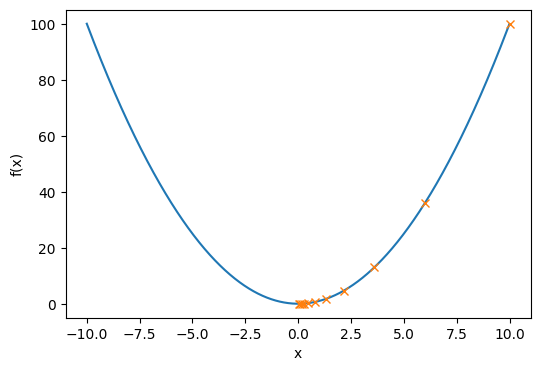

In [14]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    plt.figure(figsize=(6, 4))
    plt.plot(f_line, [f(x) for x in f_line], '-', label='f(x)')
    plt.plot(results, [f(x) for x in results], 'x', label='f(x)', linestyle='None')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.show()

show_trace(results, f)

### Learning Rate

Too small?


epoch 10, x: 3.486784


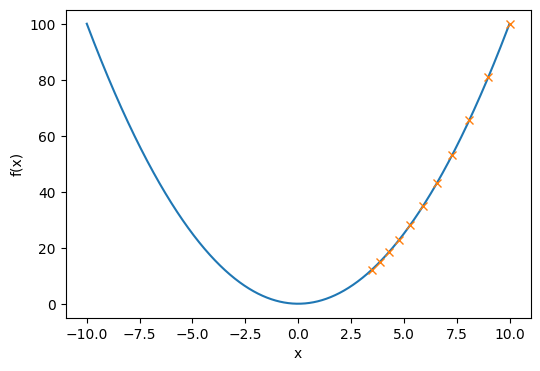

In [15]:
show_trace(gd(0.05, f_grad), f)

Too large?


epoch 10, x: 61.917364


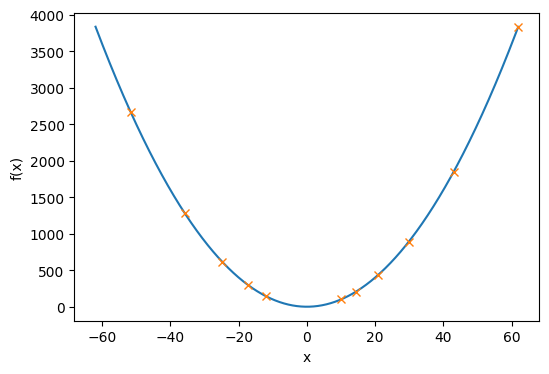

In [16]:
show_trace(gd(1.1, f_grad), f)

### Local Minima

To illustrate what happens for nonconvex functions consider the case of $f(x) = x \cdot \cos(cx)$ for some constant $c$. This function has infinitely many local minima. Depending on our choice of the learning rate and depending on how well conditioned the problem is, we may end up with one of many solutions. The example below illustrates how an (unrealistically) high learning rate will lead to a poor local minimum.


epoch 10, x: -1.528166


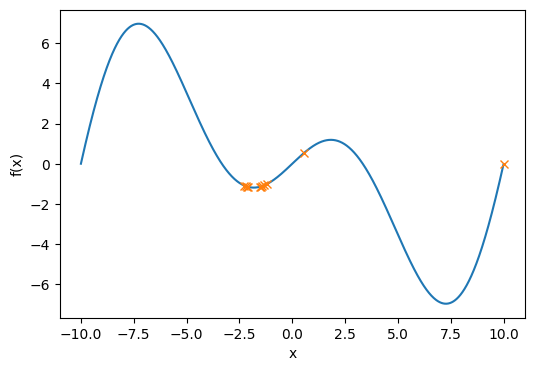

In [17]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # Objective function
    return x * torch.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

show_trace(gd(2, f_grad), f)

## Multivariate Gradient Descent

To see how the algorithm behaves in practice let's construct an objective function $f(\mathbf{x})=x_1^2+2x_2^2$ with a two-dimensional vector $\mathbf{x} = [x_1, x_2]^\top$ as input and a scalar as output. The gradient is given by $\nabla f(\mathbf{x}) = [2x_1, 4x_2]^\top$. We will observe the trajectory of $\mathbf{x}$ by gradient descent from the initial position $[-5, -2]$.

To begin with, we need two more helper functions. The first uses an update function and applies it 20 times to the initial value. The second helper visualizes the trajectory of $\mathbf{x}$.


In [18]:
#@ save
def train_2d(trainer, steps=20, f_grad=None):  
    """Optimize a 2D objective function with a customized trainer."""
    # `s1` and `s2` are internal state variables that will be used in Momentum, adagrad, RMSProp
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):
    """Show the trace of 2D variables during optimization."""
    plt.figure(figsize=(6, 4))
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1), torch.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

Next, we observe the trajectory of the optimization variable $\mathbf{x}$ for learning rate $\eta = 0.1$. We can see that after 20 steps the value of $\mathbf{x}$ approaches its minimum at $[0, 0]$. Progress is fairly well-behaved albeit rather slow.


epoch 20, x1: -0.057646, x2: -0.000073


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


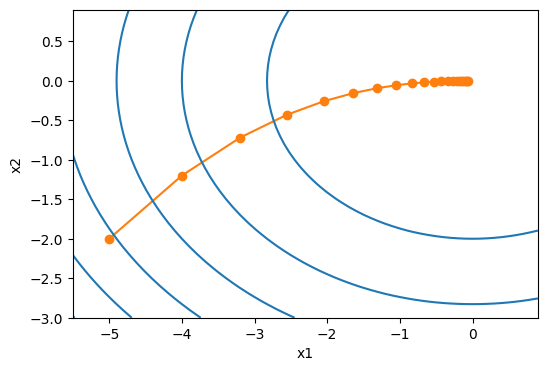

In [19]:
def f_2d(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):  # Gradient of the objective function
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

## Adaptive Methods

### Newton's Method

Let's see what happens in other problems.
Given a convex hyperbolic cosine function $f(x) = \cosh(cx)$ for some constant $c$, we can see that
the global minimum at $x=0$ is reached
after a few iterations.


epoch 10, x: tensor(0.)


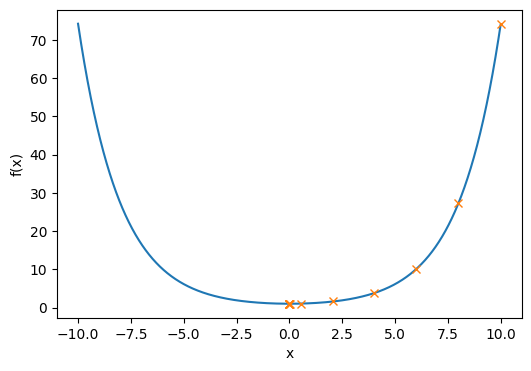

In [20]:
c = torch.tensor(0.5)

def f(x):  # Objective function
    return torch.cosh(c * x)

def f_grad(x):  # Gradient of the objective function
    return c * torch.sinh(c * x)

def f_hess(x):  # Hessian of the objective function
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

Now let's consider a *nonconvex* function, such as $f(x) = x \cos(c x)$ for some constant $c$. After all, note that in Newton's method we end up dividing by the Hessian. This means that if the second derivative is *negative* we may walk into the direction of *increasing* the value of $f$.
That is a fatal flaw of the algorithm.
Let's see what happens in practice.


epoch 10, x: tensor(26.8341)


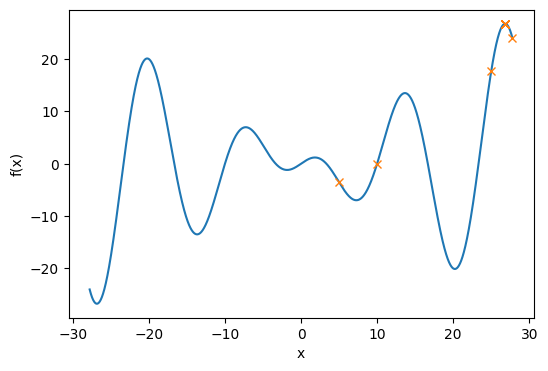

In [21]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # Objective function
    return x * torch.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x):  # Hessian of the objective function
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

show_trace(newton(), f)

This went spectacularly wrong. How can we fix it? One way would be to "fix" the Hessian by taking its absolute value instead. Another strategy is to bring back the learning rate. This seems to defeat the purpose, but not quite. Having second-order information allows us to be cautious whenever the curvature is large and to take longer steps whenever the objective function is flatter.
Let's see how this works with a slightly smaller learning rate, say $\eta = 0.5$. As we can see, we have quite an efficient algorithm.


epoch 10, x: tensor(7.2699)


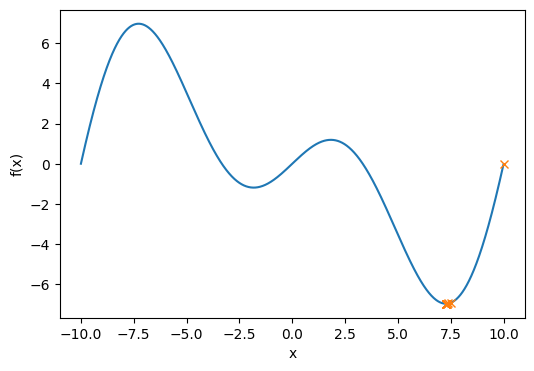

In [22]:
show_trace(newton(0.5), f)

# Stochastic Gradient Descent

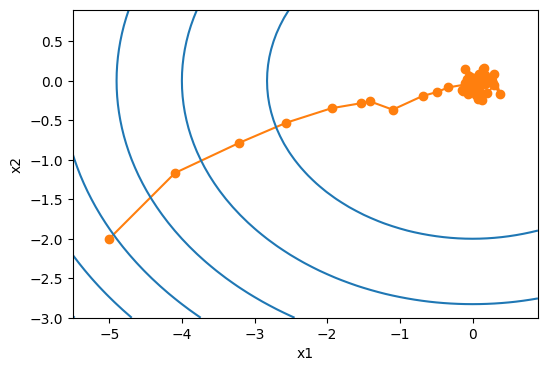

In [24]:
def f(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2

def sgd(x1, x2, s1, s2, f_grad, lr, eta):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate

results = []
x1, x2, _, _ = -5, -2, 0, 0
for i in range(50):
    results.append([x1, x2])
    x1, x2, _, _ = sgd(x1, x2, 0, 0, f_grad, lr, eta)

show_trace_2d(f, results)

## Dynamic Learning Rate

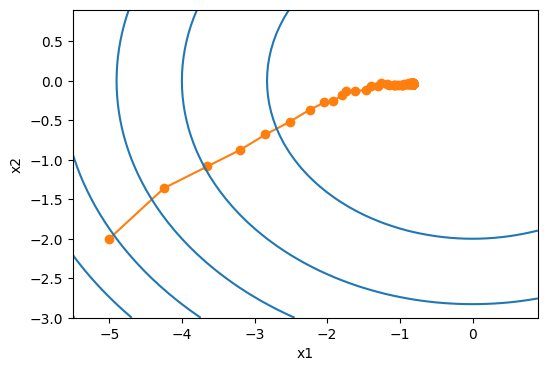

In [25]:
import math

def exponential_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr

results = []
x1, x2, _, _ = -5, -2, 0, 0
for i in range(1000):
    results.append([x1, x2])
    x1, x2, _, _ = sgd(x1, x2, 0, 0, f_grad, lr, eta)

show_trace_2d(f, results)

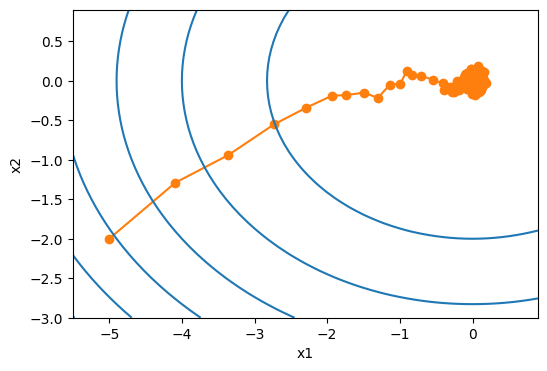

In [26]:
def polynomial_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr
results = []
x1, x2, _, _ = -5, -2, 0, 0
for i in range(1000):
    results.append([x1, x2])
    x1, x2, _, _ = sgd(x1, x2, 0, 0, f_grad, lr, eta)

show_trace_2d(f, results)

# Momentum

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

As before $f$ has its minimum at $(0, 0)$. This function is *very* flat in the direction of $x_1$. Let's see what happens when we perform gradient descent as before on this new function. We pick a learning rate of $0.4$.

epoch 20, x1: -0.943467, x2: -0.000073


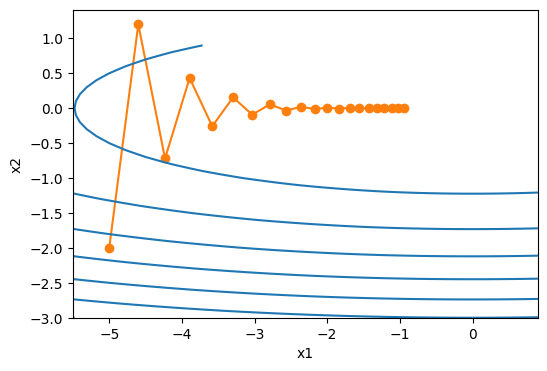

In [27]:
# With standard gradient descent

eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

The gradient in the $x_2$ direction is *much* higher and changes much more rapidly than in the horizontal $x_1$ direction. 

Thus we are stuck between two undesirable choices: 
- if we pick a small learning rate we ensure that the solution does not diverge in the $x_2$ direction but we are saddled with slow convergence in the $x_1$ direction. 

- conversely, with a large learning rate we progress rapidly in the $x_1$ direction but diverge in $x_2$. 

The example below illustrates what happens even after a slight increase in learning rate from $0.4$ to $0.6$.

epoch 20, x1: -0.387814, x2: -1673.365109


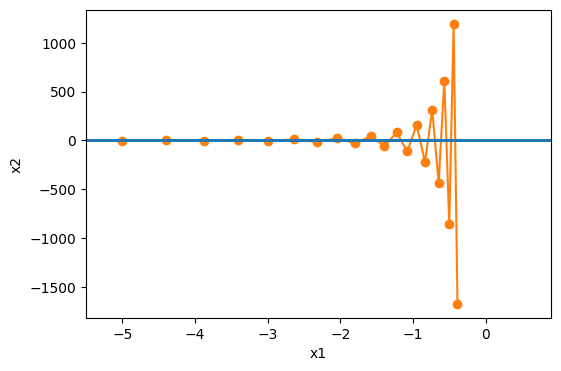

In [29]:
# With standard gradient descent

eta = 0.6

show_trace_2d(f_2d, train_2d(gd_2d))

Averaging gradients over the past would work well. 

After all, in the $x_1$ direction this will aggregate well-aligned gradients, thus increasing the distance we cover with every step. 

Conversely, in the $x_2$ direction where gradients oscillate, an aggregate gradient will reduce step size due to oscillations that cancel each other out.

Using $\mathbf{v}_t$ instead of the gradient $\mathbf{g}_t$ yields the following update equations:

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}
$$

epoch 20, x1: 0.007188, x2: 0.002553


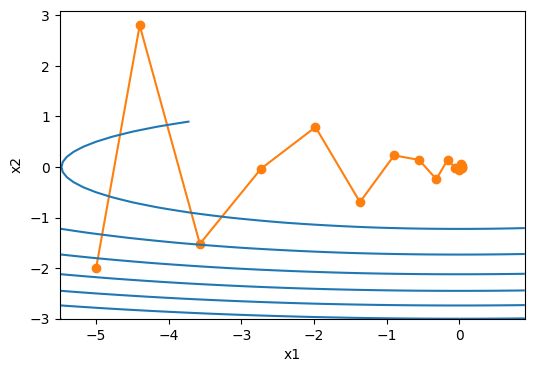

In [30]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
show_trace_2d(f_2d, train_2d(momentum_2d))

epoch 20, x1: -0.126340, x2: -0.186632


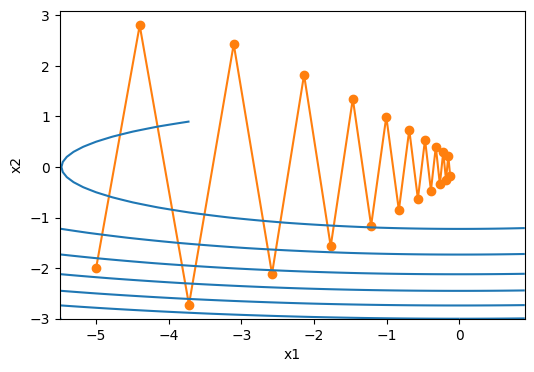

In [31]:
# Daha az momentum?

eta, beta = 0.6, 0.25
show_trace_2d(f_2d, train_2d(momentum_2d))